## Firm Dynamics - Question 1
### Wei Han Chia

In this question, we are provided a model of a firm with quadratic adjustment costs, as well as a stochastic AR-1 shock to productivity. We can solve for the firm's optimal policy using Value Function Iteration

### Set up


In [47]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

# to print plots inline
%matplotlib inline

### Parametrization
Let us begin with some preliminaries. Firstly, we will calibrate the model according to the following parameters. We also want to generate a grid for capital as well as a grid for the income shocks. We will build upon the model provided in the Deterministic Firm VFI notebook

We will use the following parametrization:


| Parameter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $w$   | Wage rate | 0.700 |
   | $r$   | Interest rate | 0.040 |
   | $\sigma_z$   | Std dev of shocks | 0.213 |
   | $\mu$ | Mean of Income Process | 0 |
   | $\rho$ | Persistence of Income Process | 0.7605 |
   | `sizez` | Number of Grid Points of z | 9 |

In [48]:
# Parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
mu = 0
rho = 0.7605
sigma_z = 0.213
size_z = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

We will generate the capital grid in the same manner as in the original model, centering our grid around the steady state value solved analytically for the model without adjustment costs. Note here that since we assume $\mu = 0$, it follows that the expected $z = 1$.

We will also use the Rouwenhorst method to discretize our income shock distribution and generate a transition probability matrix. Since we have 9 grid points, we will space our grid out to 4 standard deviations on either end when discretizing our income shock space.

In [49]:
def incomegrid(density, kstar):
    dens = density
    # Bouding state space based on steady state capital
    kbar = 2*kstar
    lb_k = 0.001
    ub_k = kbar
    krat = np.log(lb_k / ub_k)
    numb = np.ceil(krat / np.log(1 - delta))
    K = np.zeros(int(numb * dens))
    # we'll create in a way where we pin down the upper bound - since
    # the distance will be small near the lower bound, we'll miss that by little
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    kvec = K[::-1]
    return kvec

#Compute steady state capital
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))

kvec1 = incomegrid(2, kstar)

# Generating grid of transition probabilities and nodes
import ar1_approx as ar1
step = (4 * sigma_z) / (size_z/ 2)
pi, zvec1 = ar1.rouwen(rho, mu, step, size_z)

Next, we want to define our matrix for per period flows. Since we have a distribution for z, we will need to generate a 3-dimensional array. We note that the profit obtained in each period is given by:
$$\pi(k,z) =\left(1-\alpha_{l}\right)z\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

There is no change in per period flows:
$$ e(k,k') = \pi(k,z) - (k'-(1-\delta)k) - \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

In [50]:
# Function for computing profit
def profit(k,z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return ((1 - alpha_l) * ((np.exp(z)) **(1/(1-alpha_l)))* ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((k ** alpha_k) ** (1 / (1 - alpha_l))))

@numba.jit
def flows(kvec,zvec, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    e = np.zeros((size_k,size_k,size_z))
    for i in range(size_k):
        for j in range(size_k):
            for k in range(size_z):
                e[i,j,k] = (profit(kvec[i], zvec[k], params) - (kvec[j] - ((1 - delta) * kvec[i])) - 
                ((psi/2) *((kvec[j] - ((1-delta)*kvec[i]))**2)/ kvec[i]))
    return e

In [68]:
e = flows(kvec1, zvec1, params)

### VFI
Now, we can proceed with value function iteration. Note here that our Bellman equation with the price of capital normalized to 1 lies over two states

$$ V(z,k) = \max_{k'} \pi(z,k) - (k'-(1-\delta)k) - c(k',k) + \beta \mathbb{E}_{[z'|z]} V(z',k') $$
Putting this in terms of our discretized state space

$$ V(z,k) = \max_{k'} \pi(z,k) - (k'-(1-\delta)k) - c(k',k) + \beta V(z',k')*Pr(z' | z) $$
Now we want to look for the fixed point of the mapping $T(V(z,k))$, which we can get by iterating 

$$V_{i+1}(z,k) =  \max_{k'} \pi(z,k) - (k'-(1-\delta)k) - c(k',k) + \beta V_{i}(z',k')*Pr(z' | z)$$

In [52]:
#  VFI

def VFI(kvec, zvec, e, prob, params, tol=1e-6,maxiter=3000):
    '''
    kvec = grid of capital values
    zvec = grid of shock realisations
    e = grid of potential flows in each period
    prob = transition probability matrix
    params = firm level parameters
    tol = tolerance of VFI
    maxiter = maximum iterations
    
    Purpose: Compute value function and policy function through VFI
    for a dynamic firm model with quadratic adjustment costs'''
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    VFtol = tol
    VFdist = 7.0
    VFmaxiter = maxiter
    V = np.zeros((size_k, size_z))  # k by z size matrix
    Vmat = np.zeros((size_k, size_k, size_z))  # initialize Vmat matrix
    VFiter = 1
    start_time = time.clock()
    
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = V
        for i in range(size_k):  # loop over k
            for j in range(size_k):  # loop over k'
                for k in range(size_z): # Loop over z
                    Vmat[i, j,k] = e[i, j, k] + betafirm * V[j,:].dot(prob[:,k])
        V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
        VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        VFiter += 1

    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')
        
    return V, PF  # solution to the functional equation
    


In [53]:
# Backing out policy functions

@numba.jit
def policy(PF, kvec, zvec, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    optK = kvec[PF]
    optI = np.empty((size_k, size_z))
    for i in range(size_z):
        optI[:,i] = optK[:,i] - (1 - delta) * kvec
    return optK, optI


In [54]:
# Solving for Value Function and Policy Functions at Steady State
V, PF = VFI(kvec1, zvec1, e, pi, params)
optK, optI = policy(PF, kvec1, zvec1, params)

Value function converged after this many iterations: 357
VFI took  254.7020268321794  seconds to solve


### Results
We will show the results for the policy function and value functions for the range of states of the productivity shock.

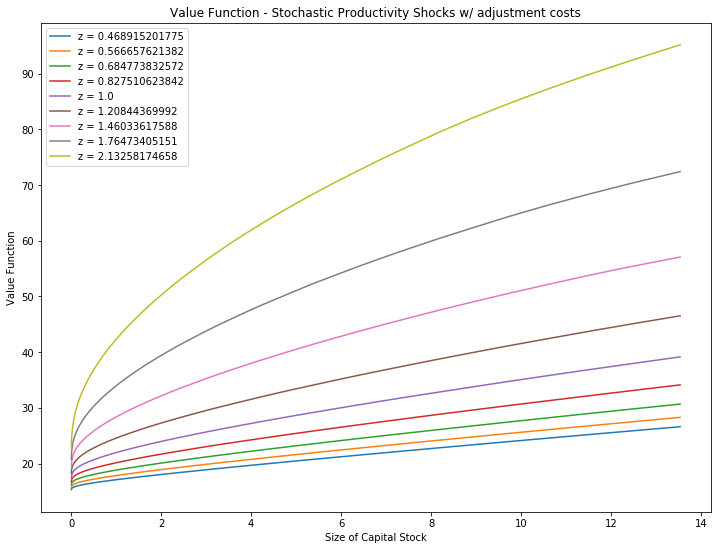

In [55]:
# Plotting Value Functions
plt.rcParams["figure.figsize"] = [12,9]
for i in range(9):
    plt.plot(kvec1, V[:,i], label='z = '+str(np.exp(zvec1[i])))
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - Stochastic Productivity Shocks w/ adjustment costs')
plt.legend()
plt.show()

As expected, our value function is concave, and increasing in productivity. This implies that the higher the productivity of the firm, the greater the value.

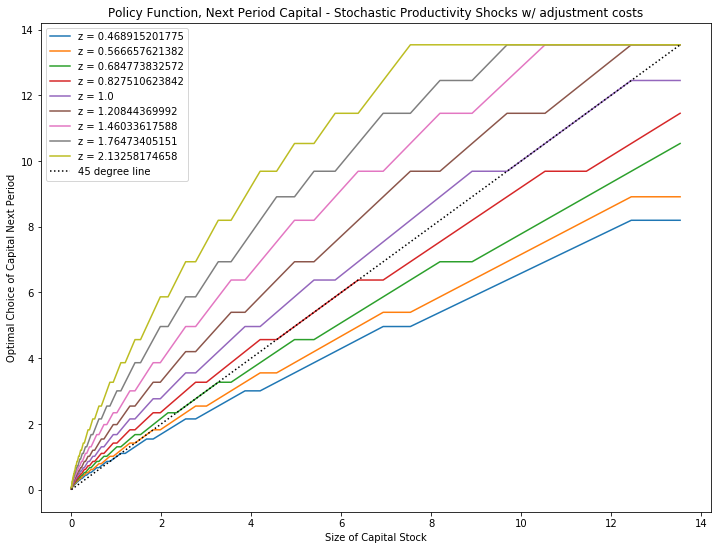

In [56]:
for i in range(9):
    plt.plot(kvec1, optK[:,i], label='z = '+str(np.exp(zvec1[i])))
plt.plot(kvec1, kvec1, 'k:', label='45 degree line')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.legend()
plt.show()

We see the same result as observed in the deterministic model, where as capital stock increases, the firms policy function falls below the 45 degree line. In addition, we note that the persistence of our productivity shock ensures that firms at currently high productivity invest more in next period capital than firms with low productivity, since these firms would expect a higher productivity next period.

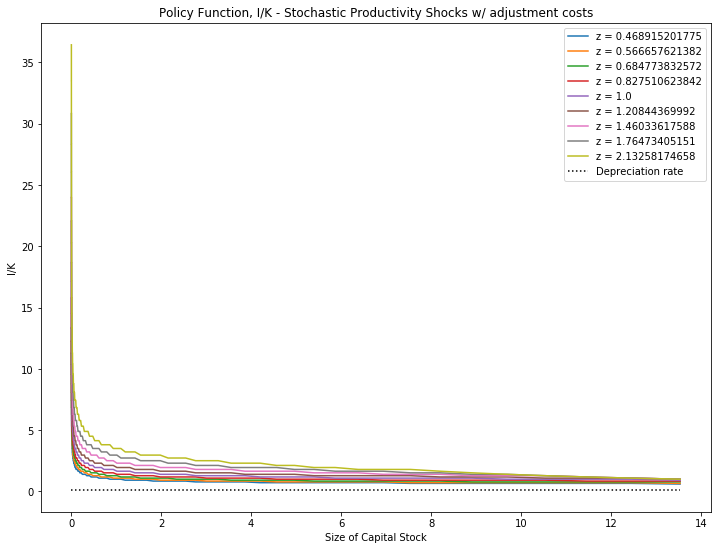

In [57]:
for i in range(9):
    plt.plot(kvec1, optK[:,i]/kvec1, label='z = '+str(np.exp(zvec1[i])))
plt.plot(kvec1,(np.ones(kvec1.shape[0])*delta), 'k:', label='Depreciation rate')
plt.xlabel('Size of Capital Stock')
plt.ylabel('I/K')
plt.title('Policy Function, I/K - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.legend()
plt.show()

Strangely, here we see that firms will always choose to invest at higher than the depreciation rate. This might be because of the presence of the productivity shock, causing precautionary investment.

In [71]:
e[1,:,1]

array([  4.86528507e-03,   4.76083721e-03,   4.63813763e-03,
         4.49393031e-03,   4.32437231e-03,   4.12492745e-03,
         3.89024064e-03,   3.61398945e-03,   3.28870864e-03,
         2.90558284e-03,   2.45420156e-03,   1.92226966e-03,
         1.29526515e-03,   5.56034899e-04,  -3.15683353e-04,
        -1.34382571e-03,  -2.55666966e-03,  -3.98762295e-03,
        -5.67615598e-03,  -7.66890377e-03,  -1.00209684e-02,
        -1.27974583e-02,  -1.60753079e-02,  -1.99454276e-02,
        -2.45152458e-02,  -2.99117130e-02,  -3.62848524e-02,
        -4.38119567e-02,  -5.27025486e-02,  -6.32042442e-02,
        -7.56096830e-02,  -9.02647190e-02,  -1.07578103e-01,
        -1.28032927e-01,  -1.52200150e-01,  -1.80754586e-01,
        -2.14493807e-01,  -2.54360474e-01,  -3.01468746e-01,
        -3.57135488e-01,  -4.22917159e-01,  -5.00653420e-01,
        -5.92518670e-01,  -7.01082970e-01,  -8.29384053e-01,
        -9.81012443e-01,  -1.16021206e+00,  -1.37199915e+00,
        -1.62230286e+00,